In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import tensorflow as tf
import os, re
import json
import requests
import time, datetime

In [2]:
def leaky_relu(x, alpha=0.1):
    x = np.where(x > 0, x, alpha*x)    
    return x

def normalize(x, x_min, x_max):
    x = (2*x - x_max - x_min) / (x_max - x_min + 1e-5)
    return x

def re_normalize(x, x_min, x_max):
    x = ((x_max - x_min + 1e-5) * x + x_max + x_min) / 2
    return x


def wind_speed_encoding(x):
    """
    风速数值化
    """
    if x == 'AUTO':
        return 1
    elif x == 'LOW':
        return 2
    elif x == 'MEDIUM':
        return 3
    elif x == 'HIGH':
        return 4
    else:
        return 0

def mode_encoding(x):
    """
    模式数值化
    """
    if x == 'AUTO':
        return 1
    elif x == 'COLD':
        return 2
    elif x == 'DEHUMI':
        return 3
    elif x == 'VENT':
        return 4
    elif x == 'HEAT':
        return 5
    else:
        return 0 
    
def power_state_encoding(x):
    if x == 'ON':
        return 1
    else:
        return 0

def plot_loss(list_train_loss, list_test_loss):
    plt.figure(figsize=(16,6))
    plt.plot(list_train_loss, label='train loss')
    plt.plot(list_test_loss, label='test loss')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)    
    plt.xlabel('Epoch', fontsize=25)
    plt.ylabel('Loss', fontsize=25)
    plt.legend(loc='best', fontsize=20)
    plt.show()
    
def plot_acc(list_train_acc, list_test_acc):
    plt.figure(figsize=(16,6))
    plt.plot(list_train_acc, label='train acc')
    plt.plot(list_test_acc, label='test acc')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)    
    plt.xlabel('Epoch', fontsize=25)
    plt.ylabel('Accuracy', fontsize=25)
    plt.legend(loc='best', fontsize=20)
    plt.show()

In [3]:
def init_model_params():
    model_params = {'Network': {'Layers': []}}
    return model_params

def fc_layer_json(model_params, layer_num, w, b):           
    x = model.weights[layer_num].shape.as_list()[0]                     #every input shape
    y = 1
    z = 1
    layer_json = {'LayerType': 'fc', 'InputSize': {'X': x, 'Y': y, 'Z': z},\
                  'OutputSize': {'X': w.shape[1], 'Y': 1, 'Z': 1}, 'Weights': [], 'Biases': {}}
    w_data = [w.transpose(1,0).tolist()]
    weights_json = {'TDSize': {'X': w.shape[0], 'Y': w.shape[1], 'Z': 1}, 'Data': w_data}
    layer_json['Weights'].append(weights_json)
    b_data = [b.reshape(-1,1).tolist()]
    biases_json = {'TDSize': {'X': 1, 'Y': b.shape[0], 'Z':1}, 'Data': b_data}
    layer_json['Biases'] = biases_json
    model_params['Network']['Layers'].append(layer_json)    
    return model_params

def relu_layer_json(model_params, layer_num):
    x = model.weights[layer_num].shape.as_list()[1]
    y = 1
    z = 1    
    layer_json = {'LayerType': 'relu', 'InputSize': {'X': x, 'Y': y, 'Z': z}}
    model_params['Network']['Layers'].append(layer_json)    
    return model_params

# 数据导入和预处理

In [4]:
df = pd.read_csv('transferdata.csv')

In [5]:
df.head()

,time,dt,power_state,temp_set,mode,wind_speed,temp_in,temp_in_start,temp_out,humid_in,humid_in_start,power_state_previous,temp_set_previous,mode_previous,wind_speed_previous,temp_in_delta,temp_in_out,temp_set_in,temp_set_out
0,2019-05-31 11:30:06,2.233333,1,16,2,4,22.3,21.4,26.0,57.1,57.0,0,0,0,0,0.9,-4.6,-5.4,-10.0
1,2019-05-31 11:35:52,8.000000,1,16,2,4,22.3,21.4,26.0,46.9,57.0,0,0,0,0,0.9,-4.6,-5.4,-10.0
2,2019-05-31 11:36:52,9.000000,1,16,2,4,21.2,21.4,26.0,46.9,57.0,0,0,0,0,-0.2,-4.6,-5.4,-10.0
3,2019-05-31 11:43:49,15.950000,1,16,2,4,21.2,21.4,26.0,46.9,57.0,0,0,0,0,-0.2,-4.6,-5.4,-10.0
4,2019-05-31 11:44:51,16.983333,1,16,2,4,20.8,21.4,26.0,40.6,57.0,0,0,0,0,-0.6,-4.6,-5.4,-10.0


In [6]:
features = ['temp_in_out', 'temp_set_in', 'temp_in_start', 'dt', 'mode', 'wind_speed', 'power_state'] # 变频
# features += ['power_state_previous', 'mode_previous'] # 变频+上一次操作
x = df[features].values.astype(np.float32)
y = df[['temp_in_delta']].values.astype(np.float32)
z = df[['temp_in_start']].values.astype(np.float32)
shuffled_indexes = np.random.permutation(x.shape[0])
x = x[shuffled_indexes]
y = y[shuffled_indexes]
z = z[shuffled_indexes]
x_min, x_max = x.min(axis=0).reshape(1,x.shape[1]), x.max(axis=0).reshape(1,x.shape[1])
y_min, y_max = y.min(), y.max()
x = normalize(x, x_min, x_max)
y = normalize(y, y_min, y_max)

In [7]:
percent = 0.7
x_train = x[:int(percent*df.shape[0])]
x_test = x[int(percent*df.shape[0]):]
y_train = y[:int(percent*df.shape[0])]
y_test = y[int(percent*df.shape[0]):]
z_train = z[:int(percent*df.shape[0])]
z_test = z[int(percent*df.shape[0]):]
time_train = df.time[:int(percent*df.shape[0])]
time_test = df.time[int(percent*df.shape[0]):]

# 训练

In [8]:
n_epochs = 100
initial_learning_rate = 0.001
n_classes = 1
batch_size = 8
n_train = len(x_train)
n_test = len(x_test)

## Keras方式训练

In [9]:
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(7,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(n_classes))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, \
                    validation_data=(x_test,y_test), verbose=True)

Train on 5873 samples, validate on 2518 samples
Epoch 1/100
5873/5873 [==============================] - 1s 200us/sample - loss: 0.0142 - mae: 0.0824 - val_loss: 0.0102 - val_mae: 0.0712
Epoch 2/100
5873/5873 [==============================] - 1s 114us/sample - loss: 0.0085 - mae: 0.0661 - val_loss: 0.0074 - val_mae: 0.0629
Epoch 3/100
5873/5873 [==============================] - 1s 114us/sample - loss: 0.0076 - mae: 0.0628 - val_loss: 0.0073 - val_mae: 0.0618
Epoch 4/100
5873/5873 [==============================] - 1s 113us/sample - loss: 0.0072 - mae: 0.0615 - val_loss: 0.0066 - val_mae: 0.0583
Epoch 5/100
5873/5873 [==============================] - 1s 114us/sample - loss: 0.0070 - mae: 0.0600 - val_loss: 0.0069 - val_mae: 0.0598
Epoch 6/100
5873/5873 [==============================] - 1s 113us/sample - loss: 0.0069 - mae: 0.0594 - val_loss: 0.0075 - val_mae: 0.0648
Epoch 7/100
5873/5873 [==============================] - 1s 114us/sample - loss: 0.0068 - mae: 0.0591 - val_loss: 0.00

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 64        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 361
Trainable params: 361
Non-trainable params: 0
__________________________________________________________

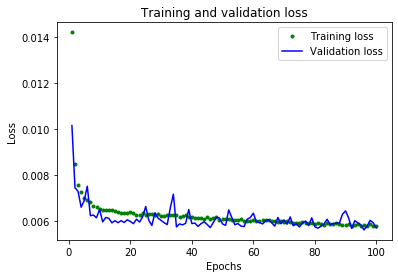

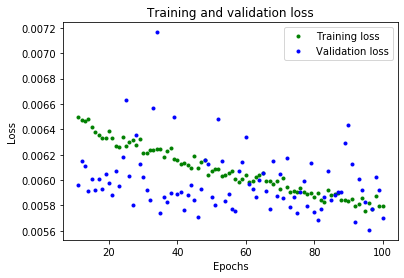

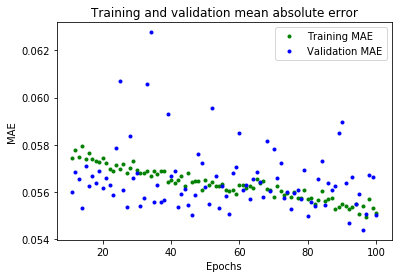

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 10

plt.clf()

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

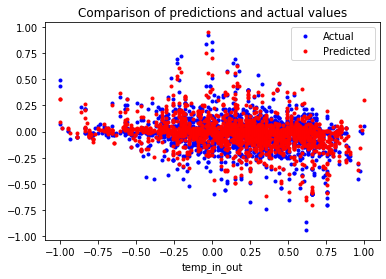

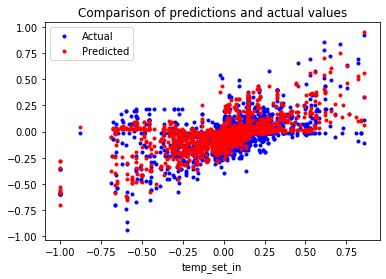

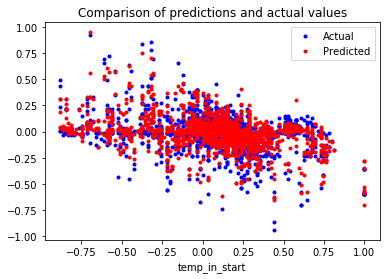

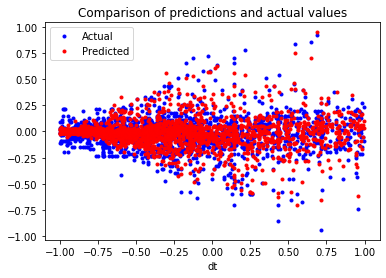

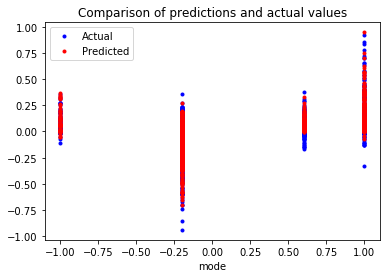

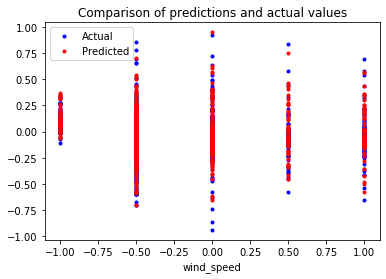

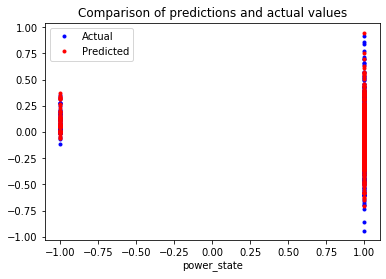

In [13]:
loss = model.evaluate(x_test, y_test, verbose=False)
predictions = model.predict(x_test)

for i in range(len(features)):
    plt.clf()
    plt.title('Comparison of predictions and actual values')
    plt.plot(x_test[:,i], y_test.reshape(len(y_test)), 'b.', label='Actual')
    plt.plot(x_test[:,i], predictions.reshape(len(predictions)), 'r.', label='Predicted')
    plt.xlabel(features[i])
    plt.legend()
    plt.show()

## tensorflow方式训练

In [14]:
def train_generator(batch_size):
    batch = 0
    while batch < n_train // batch_size:
        indexes = range(batch * batch_size, (batch + 1) * batch_size)
        batch_x_train = x_train[indexes]
        batch_y_train = y_train[indexes]
        batch += 1
        yield (batch_x_train, batch_y_train)
        
    return

def test_generator(batch_size):
    batch = 0
    while batch < n_test // batch_size:
        indexes = range(batch * batch_size, (batch + 1) * batch_size)
        batch_x_test = x_test[indexes]
        batch_y_test = y_test[indexes]
        batch += 1
        yield (batch_x_test, batch_y_test)
        
    return

In [15]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model

class TempPredModel(Model):
    def __init__(self):
        super().__init__()
        self.d1 = Dense(8, activation='relu')
        self.d2 = Dense(8, activation='relu')
        self.d3 = Dense(8, activation='relu')
        self.d4 = Dense(8, activation='relu')
        self.d5 = Dense(8, activation='relu')
        self.d6 = Dense(n_classes, activation=None)

    @tf.function
    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)
        x = self.d6(x)
        return x

In [16]:
# 需要一起更新，loss才能更新，略奇怪？

model = TempPredModel()

loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_mae')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_mae')

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_mae(y, predictions)
    
@tf.function
def test_step(x, y):
    predictions = model(x)
    loss = loss_object(y, predictions)

    test_loss(loss)
    test_mae(y, predictions)    

In [17]:
test_loss_temp = 1e10
test_mae_temp = 0

In [18]:
for epoch in range(n_epochs):
    for batch_x_train, batch_y_train in train_generator(batch_size):
        train_step(batch_x_train, batch_y_train)
        
    for batch_x_test, batch_y_test in test_generator(batch_size):
        test_step(batch_x_test, batch_y_test)

    logger = 'Epoch {}/{}: Train Loss: {:.3f}, Test Loss: {:.3f}, Train Mae: {:.3f}, Test Mae: {:.3f}'
    if (epoch+1) % 10 == 0 or (epoch+1) == 1:
        print(logger.format(epoch+1, n_epochs,
                            train_loss.result(),
                            test_loss.result(),
                            train_mae.result()*100,
                            test_mae.result()*100))
    if test_loss.result() < test_loss_temp:
        test_loss_temp = test_loss.result()
        test_mae_temp =  test_mae.result()*100
        layer_num = 0 
        w1, b1 = model.weights[layer_num].numpy(),model.weights[layer_num+1].numpy().astype(np.float64)
        layer_num += 2
        w2, b2 = model.weights[layer_num].numpy(),model.weights[layer_num+1].numpy().astype(np.float64)
        layer_num += 2
        w3, b3 = model.weights[layer_num].numpy(),model.weights[layer_num+1].numpy().astype(np.float64)
        layer_num += 2
        w4, b4 = model.weights[layer_num].numpy(),model.weights[layer_num+1].numpy().astype(np.float64)
        layer_num += 2
        w5, b5 = model.weights[layer_num].numpy(),model.weights[layer_num+1].numpy().astype(np.float64)
        layer_num += 2
        w6, b6 = model.weights[layer_num].numpy(),model.weights[layer_num+1].numpy().astype(np.float64)

Epoch 1/100: Train Loss: 0.013, Test Loss: 0.009, Train Mae: 7.601, Test Mae: 6.516
Epoch 10/100: Train Loss: 0.008, Test Loss: 0.007, Train Mae: 6.282, Test Mae: 6.041
Epoch 20/100: Train Loss: 0.007, Test Loss: 0.007, Train Mae: 6.121, Test Mae: 5.928
Epoch 30/100: Train Loss: 0.007, Test Loss: 0.007, Train Mae: 6.034, Test Mae: 5.868
Epoch 40/100: Train Loss: 0.007, Test Loss: 0.007, Train Mae: 5.976, Test Mae: 5.826
Epoch 50/100: Train Loss: 0.007, Test Loss: 0.006, Train Mae: 5.931, Test Mae: 5.797
Epoch 60/100: Train Loss: 0.007, Test Loss: 0.006, Train Mae: 5.897, Test Mae: 5.780
Epoch 70/100: Train Loss: 0.007, Test Loss: 0.006, Train Mae: 5.869, Test Mae: 5.771
Epoch 80/100: Train Loss: 0.007, Test Loss: 0.006, Train Mae: 5.845, Test Mae: 5.766
Epoch 90/100: Train Loss: 0.007, Test Loss: 0.006, Train Mae: 5.824, Test Mae: 5.760
Epoch 100/100: Train Loss: 0.007, Test Loss: 0.006, Train Mae: 5.806, Test Mae: 5.751


In [19]:
layer_num = 0                                                          #model.weights[layer_num]
model_params = init_model_params()
model_params = fc_layer_json(model_params, layer_num, w1, b1)
model_params = relu_layer_json(model_params, layer_num)
layer_num += 2
model_params = fc_layer_json(model_params, layer_num, w1, b1)
model_params = relu_layer_json(model_params, layer_num)
layer_num += 2
model_params = fc_layer_json(model_params, layer_num, w1, b1)
model_params = relu_layer_json(model_params, layer_num)
layer_num += 2
model_params = fc_layer_json(model_params, layer_num, w1, b1)
model_params = relu_layer_json(model_params, layer_num)
layer_num += 2
model_params = fc_layer_json(model_params, layer_num, w1, b1)
model_params = relu_layer_json(model_params, layer_num)
layer_num += 2
model_params = fc_layer_json(model_params, layer_num, w1, b1)
model_params = relu_layer_json(model_params, layer_num)

In [ ]:
scale = {'scale': {'xmin':list(np.float64(x_min.tolist()[0])), 'xmax':list(np.float64(x_max.tolist()[0])), 'ymin':list(np.float64([y_min])), 'ymax':list(np.float64([y_max]))}}
transfermodel = scale.copy()
transfermodel.update({'modelparams': model_params})
with open('transfermodel.txt', 'w') as f:
    content = json.dumps(transfermodel)
    f.write(content)

# 保存并转换模型为c代码

In [ ]:
cd ../edge/src/

In [ ]:
# 保存非量化模型
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("transfer_model.tflite", "wb").write(tflite_model)

# 保存量化模型
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tflite_model = converter.convert()
# open("transfer_model_quantized.tflite", "wb").write(tflite_model)

In [ ]:
# 模型转换为c代码
!xxd -i transfer_model.tflite > transfer_model.cc

In [ ]:
# 保存最值到c代码
with open('transfer_model.cc', 'a') as f:
    f.write('const float x_min[7] = {};\n'.format(str([round(i, 3) for i in x_min.tolist()[0]]).replace('[','{').replace(']','}')))
    f.write('const float x_max[7] = {};\n'.format(str([round(i, 3) for i in x_max.tolist()[0]]).replace('[','{').replace(']','}')))
    f.write('const float y_min = {:.3f};\n'.format(y_min))
    f.write('const float y_max = {:.3f};'.format(y_max))

# 对比python和c的预测结果

In [ ]:
batch_x_test[1:2]

In [ ]:
model(batch_x_test[1:2]).numpy()

In [ ]:
cd ..

In [ ]:
!./transfermodel